# Extreme Learning Machine

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from itertools import product

In [2]:
drive.mount('/content/drive')

train_path = "/content/drive/MyDrive/semester_project_2.3/afdb_train_scaled.csv"
test_path  = "/content/drive/MyDrive/semester_project_2.3/afdb_test_scaled.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

Mounted at /content/drive


#### If any columns are empty, we fill them with the mean and then we remove the 'label' column

In [3]:
# fill empty columns with mean
train = train.fillna(train.mean())
test  = test.fillna(test.mean())

# split features and labels
X_train = train.iloc[:, :-1].values.astype(np.float32)
y_train = train.iloc[:, -1].values.astype(int)

X_test = test.iloc[:, :-1].values.astype(np.float32)
y_test = test.iloc[:, -1].values.astype(int)

#### Define ELM model

In [4]:
class ELM:
    def __init__(self, input_size, hidden_size, activation):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.activation = activation
        self.W = np.random.randn(self.input_size, self.hidden_size)
        self.b = np.random.randn(self.hidden_size)
        self.beta = None

    def _activate(self, X):
        H = X @ self.W + self.b
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-H))
        elif self.activation == 'tanh':
            return np.tanh(H)
        elif self.activation == 'relu':
            return np.maximum(0, H)
        else:
            raise ValueError("Unsupported activation")

    def fit(self, X, y, C=1e3):
        enc = OneHotEncoder(sparse_output=False)
        Y = enc.fit_transform(y.reshape(-1,1))
        H = self._activate(X)
        I = np.eye(self.hidden_size)
        self.beta = np.linalg.solve(H.T @ H + I / C, H.T @ Y)
        self.enc = enc

    def predict(self, X):
        H = self._activate(X)
        Y_pred = H @ self.beta
        return self.enc.inverse_transform(Y_pred).ravel().astype(int)

#### Let's test a simple ELM model

Classification Report:

              precision    recall  f1-score   support

      Normal       0.98      0.95      0.96      3497
        AFib       0.93      0.98      0.95      2500

    accuracy                           0.96      5997
   macro avg       0.96      0.96      0.96      5997
weighted avg       0.96      0.96      0.96      5997



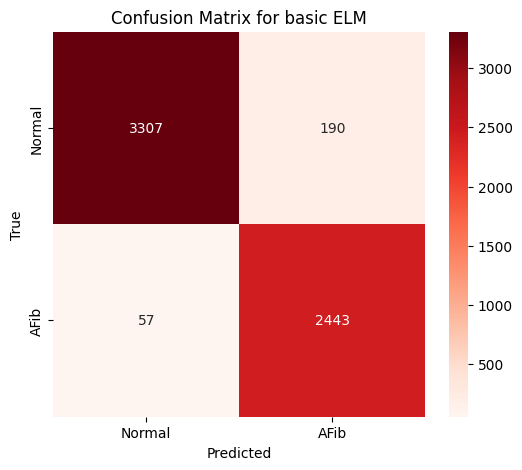

In [5]:
# define, fit and evaluate a simple ELM
elm_simple = ELM(input_size=X_train.shape[1], hidden_size=50, activation='sigmoid')
elm_simple.fit(X_train, y_train, C=1e1)
y_pred_simple = elm_simple.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred_simple, target_names=['Normal','AFib']))

cm = confusion_matrix(y_test, y_pred_simple)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=['Normal','AFib'], yticklabels=['Normal','AFib'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for basic ELM")
plt.show()

## Grid Search

#### The simple ELM already did great, but let's do a grid search to find  the optimal one

In [6]:
# grid search params
hidden_sizes = [10, 50, 100, 500, 1000, 1500]
activations  = ['sigmoid', 'tanh', 'relu']
Cs           = [1e1, 1e2, 1e3, 1e4, 1e5]

# best configuration metrics and params
best_f1 = 0
best_config = {}

# all results (for inspection)
results = []

# -----------
# grid search
#------------
for hs, act, C in product(hidden_sizes, activations, Cs):
    elm = ELM(input_size=X_train.shape[1], hidden_size=hs, activation=act)
    elm.fit(X_train, y_train, C=C)
    y_pred = elm.predict(X_test)

    # compute metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # save results
    results.append({
        'hidden_size': hs,
        'activation': act,
        'C': C,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

    # track best
    if f1 > best_f1:
        best_f1 = f1
        best_config = {
            'hidden_size': hs,
            'activation': act,
            'C': C,
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'pred_labels': y_pred.copy()
        }

    print(f"Just completed:\nhidden_size={hs}, activation={act}, C={C}")
    print(f"Accuracy={acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}\n")

# convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df

Just completed:
hidden_size=10, activation=sigmoid, C=10.0
Accuracy=0.9206, Precision=0.8538, Recall=0.9768, F1=0.9112

Just completed:
hidden_size=10, activation=sigmoid, C=100.0
Accuracy=0.9258, Precision=0.8721, Recall=0.9632, F1=0.9154

Just completed:
hidden_size=10, activation=sigmoid, C=1000.0
Accuracy=0.9141, Precision=0.8744, Recall=0.9272, F1=0.9000

Just completed:
hidden_size=10, activation=sigmoid, C=10000.0
Accuracy=0.9243, Precision=0.8680, Recall=0.9652, F1=0.9140

Just completed:
hidden_size=10, activation=sigmoid, C=100000.0
Accuracy=0.9171, Precision=0.8583, Recall=0.9596, F1=0.9061

Just completed:
hidden_size=10, activation=tanh, C=10.0
Accuracy=0.9250, Precision=0.8607, Recall=0.9784, F1=0.9158

Just completed:
hidden_size=10, activation=tanh, C=100.0
Accuracy=0.9175, Precision=0.8698, Recall=0.9432, F1=0.9050

Just completed:
hidden_size=10, activation=tanh, C=1000.0
Accuracy=0.9068, Precision=0.8366, Recall=0.9648, F1=0.8962

Just completed:
hidden_size=10, acti

/tmp/ipython-input-2437918333.py:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-H))


Just completed:
hidden_size=100, activation=sigmoid, C=10.0
Accuracy=0.9615, Precision=0.9362, Recall=0.9740, F1=0.9547

Just completed:
hidden_size=100, activation=sigmoid, C=100.0
Accuracy=0.9618, Precision=0.9376, Recall=0.9732, F1=0.9551

Just completed:
hidden_size=100, activation=sigmoid, C=1000.0
Accuracy=0.9576, Precision=0.9323, Recall=0.9688, F1=0.9502



/tmp/ipython-input-2437918333.py:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-H))


Just completed:
hidden_size=100, activation=sigmoid, C=10000.0
Accuracy=0.9628, Precision=0.9415, Recall=0.9712, F1=0.9561

Just completed:
hidden_size=100, activation=sigmoid, C=100000.0
Accuracy=0.9600, Precision=0.9333, Recall=0.9736, F1=0.9530

Just completed:
hidden_size=100, activation=tanh, C=10.0
Accuracy=0.9515, Precision=0.9123, Recall=0.9776, F1=0.9438

Just completed:
hidden_size=100, activation=tanh, C=100.0
Accuracy=0.9646, Precision=0.9420, Recall=0.9752, F1=0.9583

Just completed:
hidden_size=100, activation=tanh, C=1000.0
Accuracy=0.9566, Precision=0.9281, Recall=0.9712, F1=0.9492

Just completed:
hidden_size=100, activation=tanh, C=10000.0
Accuracy=0.9605, Precision=0.9327, Recall=0.9756, F1=0.9537

Just completed:
hidden_size=100, activation=tanh, C=100000.0
Accuracy=0.9575, Precision=0.9276, Recall=0.9740, F1=0.9502

Just completed:
hidden_size=100, activation=relu, C=10.0
Accuracy=0.9621, Precision=0.9353, Recall=0.9768, F1=0.9556

Just completed:
hidden_size=100, 

/tmp/ipython-input-2437918333.py:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-H))


Just completed:
hidden_size=1000, activation=sigmoid, C=100000.0
Accuracy=0.9630, Precision=0.9388, Recall=0.9748, F1=0.9564

Just completed:
hidden_size=1000, activation=tanh, C=10.0
Accuracy=0.9655, Precision=0.9463, Recall=0.9724, F1=0.9592

Just completed:
hidden_size=1000, activation=tanh, C=100.0
Accuracy=0.9648, Precision=0.9438, Recall=0.9736, F1=0.9585

Just completed:
hidden_size=1000, activation=tanh, C=1000.0
Accuracy=0.9623, Precision=0.9383, Recall=0.9736, F1=0.9556

Just completed:
hidden_size=1000, activation=tanh, C=10000.0
Accuracy=0.9620, Precision=0.9400, Recall=0.9708, F1=0.9551

Just completed:
hidden_size=1000, activation=tanh, C=100000.0
Accuracy=0.9636, Precision=0.9422, Recall=0.9724, F1=0.9571

Just completed:
hidden_size=1000, activation=relu, C=10.0
Accuracy=0.9621, Precision=0.9386, Recall=0.9728, F1=0.9554

Just completed:
hidden_size=1000, activation=relu, C=100.0
Accuracy=0.9645, Precision=0.9410, Recall=0.9760, F1=0.9582

Just completed:
hidden_size=10

/tmp/ipython-input-2437918333.py:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-H))


Just completed:
hidden_size=1500, activation=sigmoid, C=10000.0
Accuracy=0.9593, Precision=0.9355, Recall=0.9692, F1=0.9521

Just completed:
hidden_size=1500, activation=sigmoid, C=100000.0
Accuracy=0.9621, Precision=0.9397, Recall=0.9716, F1=0.9554

Just completed:
hidden_size=1500, activation=tanh, C=10.0
Accuracy=0.9600, Precision=0.9366, Recall=0.9696, F1=0.9528

Just completed:
hidden_size=1500, activation=tanh, C=100.0
Accuracy=0.9636, Precision=0.9429, Recall=0.9716, F1=0.9571

Just completed:
hidden_size=1500, activation=tanh, C=1000.0
Accuracy=0.9621, Precision=0.9390, Recall=0.9724, F1=0.9554

Just completed:
hidden_size=1500, activation=tanh, C=10000.0
Accuracy=0.9625, Precision=0.9435, Recall=0.9680, F1=0.9556

Just completed:
hidden_size=1500, activation=tanh, C=100000.0
Accuracy=0.9598, Precision=0.9353, Recall=0.9708, F1=0.9527

Just completed:
hidden_size=1500, activation=relu, C=10.0
Accuracy=0.9611, Precision=0.9365, Recall=0.9728, F1=0.9543

Just completed:
hidden_si

,hidden_size,activation,C,accuracy,precision,recall,f1_score
0,10,sigmoid,10.0,0.920627,0.853846,0.9768,0.911194
1,10,sigmoid,100.0,0.925796,0.872148,0.9632,0.915415
2,10,sigmoid,1000.0,0.914124,0.874387,0.9272,0.900019
3,10,sigmoid,10000.0,0.924295,0.867986,0.9652,0.914015
4,10,sigmoid,100000.0,0.917125,0.858318,0.9596,0.906138
...,...,...,...,...,...,...,...
85,1500,relu,10.0,0.961147,0.936465,0.9728,0.954287
86,1500,relu,100.0,0.962815,0.940085,0.9728,0.956163
87,1500,relu,1000.0,0.960647,0.938420,0.9692,0.953562
88,1500,relu,10000.0,0.964315,0.941995,0.9744,0.957924


Optimal Configuration
hidden size=50, activation: sigmoid, C=1000.0

Accuracy: 96.85%
Precision: 0.9501
Recall: 0.9756
F1-score: 0.9627

Classification Report:

              precision    recall  f1-score   support

      Normal       0.98      0.96      0.97      3497
        AFib       0.95      0.98      0.96      2500

    accuracy                           0.97      5997
   macro avg       0.97      0.97      0.97      5997
weighted avg       0.97      0.97      0.97      5997



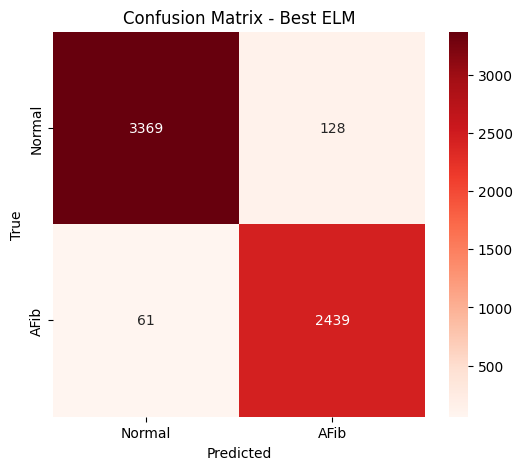

In [7]:
# summarize best result
print("Optimal Configuration")
print(f"hidden size={best_config['hidden_size']}, activation: {best_config['activation']}, C={best_config['C']}\n")
print(f"Accuracy: {best_config['accuracy']*100:.2f}%")
print(f"Precision: {best_config['precision']:.4f}")
print(f"Recall: {best_config['recall']:.4f}")
print(f"F1-score: {best_config['f1_score']:.4f}\n")

# use best configuration for final evaluation metrics
y_pred_best = best_config['pred_labels']

# classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_best, target_names=['Normal','AFib']))

# confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
cm_labels = ['Normal', 'AFib']
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Best ELM')
plt.show()